# Deploying the CNN

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import nibabel as nib
import os
import glob
import sys
import time
MY_UTILS_PATH = "../Modules/"
if not MY_UTILS_PATH in sys.path:
    sys.path.append(MY_UTILS_PATH)
import ipt_utils
import cnn_utils
import metrics_utils

Using TensorFlow backend.


In [6]:
base_path = "/media/roberto/DATA/GDrive/MR-Data/LPBA40/LPBA40/native_space_radio/"
subjects = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path,f))]
masks_list = [os.path.join(base_path,f,"tissue",f + ".native_radio.tissue.img") for f in subjects]
brain_list = [os.path.join(base_path,f,f + ".native_radio.brain.mask.img") for f in subjects]
imgs_list = [os.path.join(base_path,f,f + ".native_radio.mri.img") for f in subjects]

print len(imgs_list)
print imgs_list[0]
print masks_list[0]
print brain_list[0]
stats = np.load("../Data/wm_unet_cc347.npy")
mean = stats[0]
std = stats[1]

model_path = "../Data/wm_unet_cc_347_best.hdf5"

40
/media/roberto/DATA/GDrive/MR-Data/LPBA40/LPBA40/native_space_radio/S01/S01.native_radio.mri.img
/media/roberto/DATA/GDrive/MR-Data/LPBA40/LPBA40/native_space_radio/S01/tissue/S01.native_radio.tissue.img
/media/roberto/DATA/GDrive/MR-Data/LPBA40/LPBA40/native_space_radio/S01/S01.native_radio.brain.mask.img


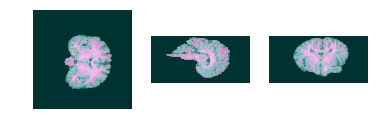

uint8


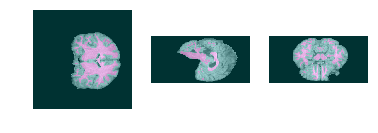

uint8


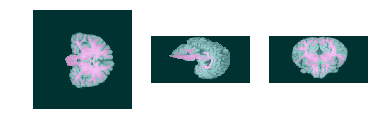

uint8


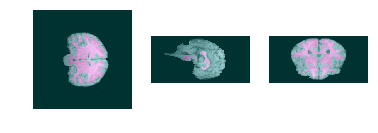

uint8


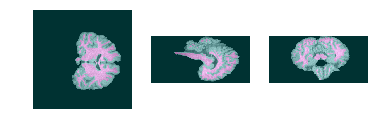

uint8


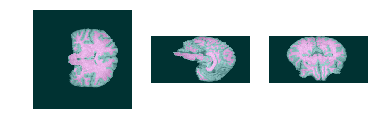

uint8


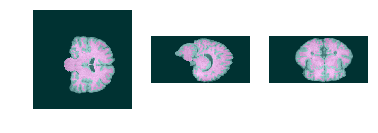

uint8


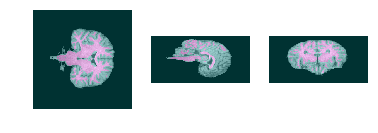

uint8


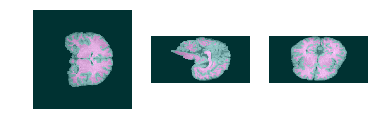

uint8


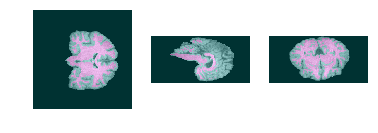

uint8


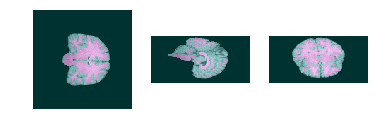

uint8


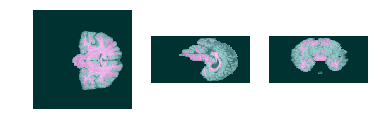

uint8


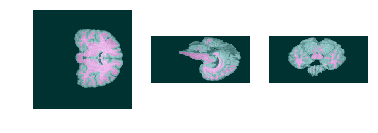

uint8


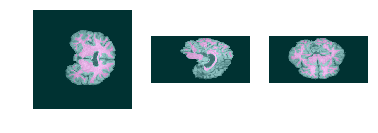

uint8


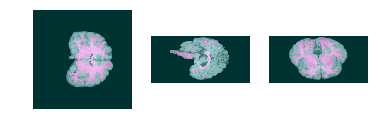

uint8


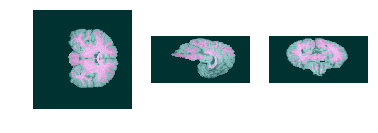

uint8


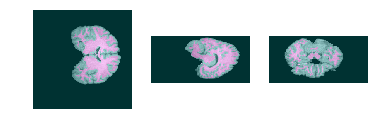

uint8


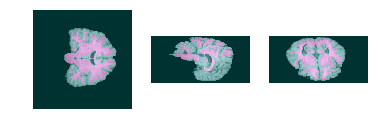

uint8


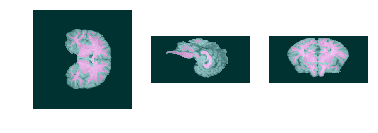

uint8


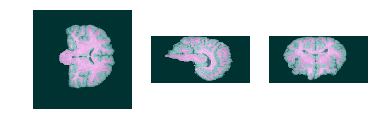

uint8


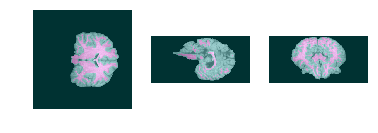

uint8


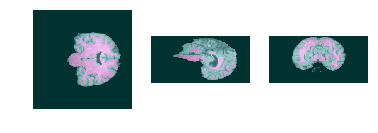

uint8


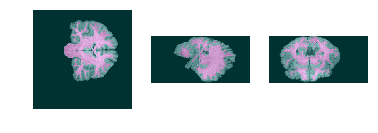

uint8


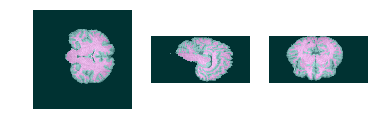

uint8


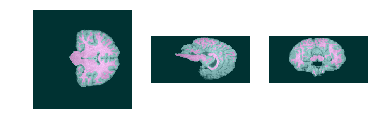

uint8


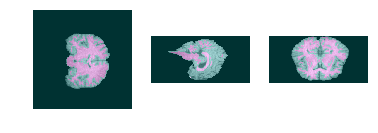

uint8


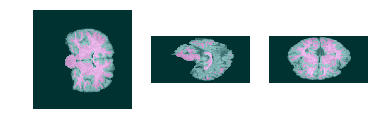

uint8


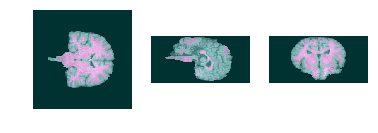

uint8


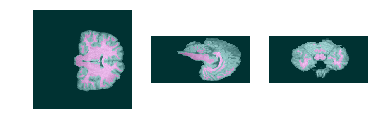

uint8


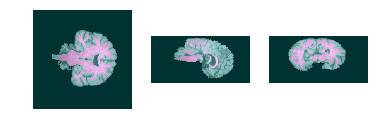

uint8


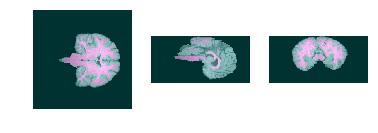

uint8


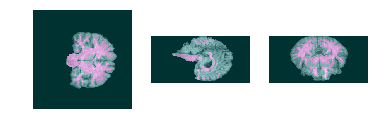

uint8


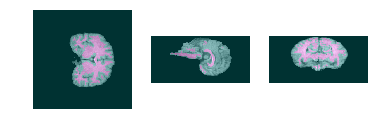

uint8


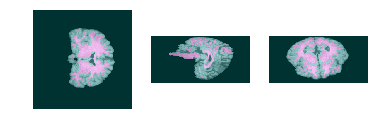

uint8


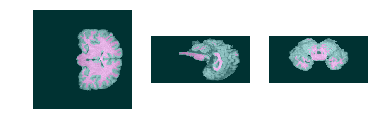

uint8


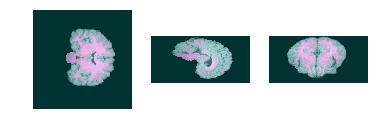

uint8


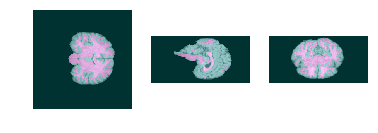

uint8


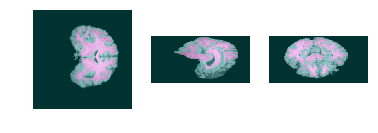

uint8


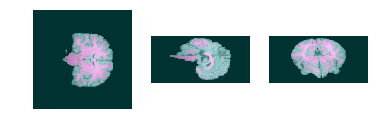

uint8


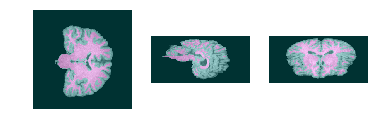

uint8


In [16]:
model = cnn_utils.get_unet_mod()
model.load_weights(model_path)
dice = np.zeros(40)
for ii in xrange(len(imgs_list)):
    img = nib.load(imgs_list[ii])
    affine = img.affine
    img = img.get_data()[:,:,:,0]
    brain = nib.load(brain_list[ii])
    brain = brain.get_data()[:,:,:,0] > 0
    img = img*brain
    img = img.transpose(1,0,2)
    img_min = img.min()
    img_max = img.max()
    img_norm = 1.0*(img - img_min)/(img_max-img_min)
    img_norm -= mean
    img_norm /= std
    x,y,z = img_norm.shape
    img_rgb = np.zeros((x-2,y,z,3))
    img_rgb[:,:,:,0] = img_norm[0:-2,:,:]
    img_rgb[:,:,:,1] = img_norm[1:-1,:,:]
    img_rgb[:,:,:,2] = img_norm[2:,:,:]
    img_rgb,nw,nz  = cnn_utils.pad_images(img_rgb)
    predict = model.predict(img_rgb)
    predict = predict[:,:-nw,:-nz,0]
    predict2 = np.zeros((x,y,z))
    predict2[1:-1,:,:] = predict
    predict2 = (predict2 >0.5).astype(np.uint8)
    H,W,Z = img_norm.shape
    plt.figure()
    plt.subplot(131)
    plt.imshow(img_norm[H/2,:,:], cmap = 'gray')
    plt.imshow(predict2[H/2,:,:], cmap = 'cool',alpha = 0.2)
    plt.axis("off")
    plt.subplot(132)
    plt.imshow(img_norm[:,W/2,:], cmap = 'gray')
    plt.imshow(predict2[:,W/2,:], cmap = 'cool',alpha = 0.2)
    plt.axis("off")
    plt.subplot(133)
    plt.imshow(img_norm[:,:,Z/2], cmap = 'gray')
    plt.imshow(predict2[:,:,Z/2], cmap = 'cool',alpha = 0.2)
    plt.axis("off")
    plt.show()
    mask = nib.load(masks_list[ii]).get_data()[:,:,:,0].transpose(1,0,2) == 3
    dice[ii] = metrics_utils.dice(mask,predict2)  
    seg = (predict2+2*(predict2!=mask)).transpose(1,0,2).astype(np.uint8)
    print seg.dtype
    ipt_utils.save_seg(seg,affine,os.path.join("./Predict/",subjects[ii] + "_cnn.nii.gz"))
    

In [10]:
print dice.mean()

0.745018627718


In [11]:
print dice

[ 0.73346582  0.7347688   0.76084476  0.83512447  0.79074754  0.71053284
  0.69222672  0.67505693  0.72831619  0.88708188  0.73096999  0.78652868
  0.7030459   0.75330315  0.6838607   0.74204103  0.69827633  0.69977314
  0.7251826   0.77747371  0.7670534   0.77216158  0.83105014  0.72105792
  0.71306219  0.75656822  0.72012263  0.76926737  0.70481476  0.75735299
  0.66652371  0.83775234  0.73751191  0.69621959  0.76114269  0.75389388
  0.73613147  0.70327931  0.77411342  0.77304441]
